In [2]:
from astroquery.jplhorizons import Horizons
from astroquery.jplsbdb import SBDB
from astropy.table import QTable
import astropy.units as u

#import pandas as pd
import numpy as np
import requests
from pprint import pprint
from array import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define access to JPL SBDB

In [3]:
sbdb = SBDB.query('2001VB', neo_only=True, full_precision=True, phys=True, virtual_impactor=True)
type(sbdb['vi_data']['date'][0])

str

In [4]:
def get_dict(name_list):
    # Return information for each bodies in name_list from JPL Small Body Database in form of dictionair
    # INPUT
    # name_list      list [name1, name2, ..., nameN]
    # OUTPUT
    # dict_bodies    dict with the following structure
    # str(name): "fullname"
    #         "our_id"                is the id inside the new dict, from 0 to N-1 where N is the name_list length
    #         "neo_flag"
    #         "orbit_class"
    #         "pha_flag"
    #         "object_kind"
    #         "moid"
    #         "condition_code"
    #         "rms"
    #         "orbit_comment"
    #         "magn_radius_flag"      is "H" if the next parameter is the magnitude, is "D" if the next parameter is the diameter
    #         "H" or "D"
    #         "spectral_category_flag"     T, S or 0
    #         "spectral_category"
    #         "impacts": str(impact id):   'width'  
    #                                      'energy'
    #                                      'stretch'
    #                                      'ip'
    #                                      'dt'
    #                                      'date'
    #                                      'sigma_lov'
    #                                      'h'
    #                                      'mass'
    #                                      'v_inf'
    #                                      'sigma_imp'
    #                                      'method'
    #                                      'ts'
    #                                      'diam'
    #                                      'dist'
    #                                      'v_imp'
    #                                      'ps'
    
    our_id=0;
    dict_bodies={};

    for name in name_list:
        sbdb = SBDB.query(name, neo_only=True, full_precision=True, phys=True, virtual_impactor=True)
        if sbdb["object"]["kind"]!='cn' or sbdb["object"]["kind"]!='cu' :
            asteroid={"fullname": sbdb["object"]["fullname"],# TODO vogliamo fare un check?
              "our_id":our_id,
              "neo_flag": sbdb["object"]["neo"],
              "orbit_class":sbdb["object"]["orbit_class"]["code"],
              "pha_flag":sbdb["object"]["pha"],
              "object_kind":sbdb["object"]["kind"], #an asteroid numbered au unbered asteroid (cn, cu for comet)
              "moid": sbdb["orbit"]["moid"],
              "condition_code": sbdb["orbit"]["condition_code"], #OCC
              "rms": sbdb["orbit"]["rms"],
              "orbit_comment":sbdb["orbit"]["comment"],
             };
            try:     
                asteroid["magn_radius_flag"]='H';
                asteroid["H"]=sbdb['phys_par']['H'];
            except:
                asteroid["magn_radius_flag"]='D';
                asteroid["D"]=sbdb['phys_par']['diameter'];
            asteroid["impacts"]={}
            flag_bool=1;
            if 'phys_par' in sbdb.keys():
                spect_flag=0;
                if 'spec_T' in sbdb['phys_par'].keys():
                    asteroid["spectral_category_flag"]='T'
                    asteroid["spectral_category"]=sbdb['phys_par']['spec_T']
                    spect_flag=1;
                if 'spec_B' in sbdb['phys_par'].keys():
                    asteroid["spectral_category_flag"]='B'
                    asteroid["spectral_category"]=sbdb['phys_par']['spec_B']
                    spect_flag=1;
                if spect_flag==0:
                    asteroid["spectral_category_flag"]='0'
            else:
                asteroid["spectral_category"]='0'
                
            if 'ip' in sbdb["vi_data"]:
                n_imp=len(sbdb["vi_data"]['ip']);
                for key in sbdb["vi_data"].keys():
                    if flag_bool==1:
                        for i in range(0,n_imp):
                            asteroid["impacts"][str(i)]={};
                        flag_bool=0;
                    for i in range(0,n_imp): 
                        try:
                            if isinstance(sbdb["vi_data"][key],str):
                                asteroid["impacts"][str(i)][key]=sbdb["vi_data"][key];
                            else:
                                asteroid["impacts"][str(i)][key]=sbdb["vi_data"][key][i];
                        except:
                            pprint(name+" could raise error in importing virtual impact data") #this exception is raised if only one impact is present
            dict_bodies[name]=asteroid;
            our_id=our_id+1;
            flag_bool=1;
            del asteroid;
    return dict_bodies
        

# Extract ESA risk list

In [5]:
def extract_esa_name_from_file(file_name):
    f = open(file_name, "r")
    line=f.readline()
    line=f.readline()
    line=f.readline()
    line=f.readline()
    counter=0;
    esa_names=[]
    for line in f:
        word="";
        for c in line:
            if c==' ':
                break;
            else:
                word=word+c;
        esa_names.append(word);  
    return esa_names

In [6]:
esa_risk_names=extract_esa_name_from_file("esa_risk_list.txt");

# Extract SENTRY risk list

In [7]:
def get_sentry_risk_list():
    url = 'https://ssd-api.jpl.nasa.gov/sentry.api'
    r = requests.get(url)
    data = r.json()
    sentry_risk_names=[];
    for i in range(0,len(data['data'])):
        name_=""
        name=data['data'][i]['des'];
        for c in name:
            if c==' ':
                a=0;
            else:
                name_=name_+c;
        sentry_risk_names.append(name_)
    return sentry_risk_names


In [8]:
sentry_risk_names=get_sentry_risk_list()

# Merge risk lists

In [9]:
risk_list=esa_risk_names;
counter=0;
for risk_name in sentry_risk_names:
    if risk_name not in esa_risk_names:
        risk_list.append(risk_name)

# Query SBDB for all risk list elements

In [10]:
dict_risk_list=get_dict(risk_list);

'29075 could raise error in importing virtual impact data'


# DB visualization

# MOID & H

'2010MA113 does not have magnitude info'
'2010MY112 does not have magnitude info'
'2010MZ112 does not have magnitude info'


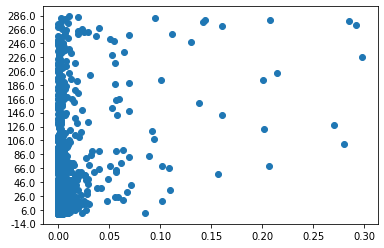

In [11]:
H_=[];
MOID_=[];
for key in dict_risk_list:
    try:
        H_.append(dict_risk_list[key]['H']);
        MOID_.append(dict_risk_list[key]['moid'].scale)
    except:
        pprint(key+' does not have magnitude info')
x = MOID_
y = H_
fig, ax = plt.subplots()
ax.plot(x,y, marker='o', linewidth=0)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-14, 306, 20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

'2010MA113 does not have magnitude info'
'2010MY112 does not have magnitude info'
'2010MZ112 does not have magnitude info'


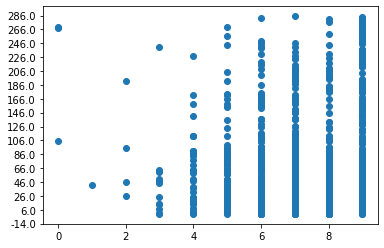

In [29]:
H_=[];
OCC_=[];
for key in dict_risk_list:
    try:
        H_.append(dict_risk_list[key]['H']);
        OCC_.append(int(dict_risk_list[key]['condition_code']))
    except:
        pprint(key+' does not have magnitude info')
x = OCC_
y = H_
fig, ax = plt.subplots()
ax.plot(x,y, marker='o', linewidth=0)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-14, 306, 20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

# List only asteroids with known spectral type

In [12]:
spectral_known=[];
for key in dict_risk_list.keys():
    if (dict_risk_list[key]['spectral_category_flag']=="B") or (dict_risk_list[key]['spectral_category_flag']=="T"):
        spectral_known.append('key');
        pprint(key)

'101955'


# Requirements filter

# MOID<=0.05au, H<=22 (if H is not available diameter>=400m)

In [13]:
MOID_H_selected=[];
for key in dict_risk_list.keys():
    if float(dict_risk_list[key]['moid'].scale)<=0.05: #MOID<=0.05 AU
        if (dict_risk_list[key]["magn_radius_flag"]=='H' and float(dict_risk_list[key]["H"])<=22) or (dict_risk_list[key]["magn_radius_flag"]=='D' and float(dict_risk_list[key]["D"])>=400):
            MOID_H_selected.append(key)

# At least one impact 2026<year<22048 with a Palermo Scale>=-8

In [14]:
date_selected=[];
PS_date_selected=[]
for key in dict_risk_list.keys():
    if '0' in dict_risk_list[key]['impacts'].keys():
        max_P=-100;
        date_flag=0;
        for imp_id in dict_risk_list[key]['impacts'].keys():
            word='';
            for c in dict_risk_list[key]['impacts'][imp_id]['date']:
                #pprint(c)
                if c=='-':
                    break;
                else:
                    word=word+c;
            if int(word)<2048 and int(word)>2026:
                date_flag=1;
                if float(dict_risk_list[key]['impacts'][imp_id]['ps'])>max_P:
                    max_P=float(dict_risk_list[key]['impacts'][imp_id]['ps']);
        if date_flag==1:
            date_selected.append(key)
            if max_P>=-8:
                PS_date_selected.append(key)

In [15]:
key

'2021AS3'

# Intersect filtered lists

In [16]:
refined_selected=list(set(PS_date_selected) & set(MOID_H_selected))

# REPORT RESULTS:

In [17]:
pprint('on date and PS:')
pprint(PS_date_selected)
pprint('on MOID and H:')
pprint(MOID_H_selected)
pprint('refined search:')
pprint(refined_selected)

'on date and PS:'
['2008JL3',
 '2011DU9',
 '2012QD8',
 '2005QK76',
 '2020VV',
 '2007DX40',
 '2007KE4',
 '2015YJ',
 '2018TY4',
 '2005ED224',
 '2017AE21',
 '2014MR26',
 '2016DK1',
 '2012MF7',
 '2008CC71',
 '2017SF20',
 '2007FT3',
 '2020XE',
 '2006DM63',
 '2018DQ',
 '2010VQ',
 '2013EV27',
 '2014ML67',
 '2009TD17',
 '2019JO1',
 '2017QC36',
 '2020UE',
 '1995CS',
 '2021FU',
 '2008TE',
 '2020VB5',
 '2012VE77',
 '2020BW5',
 '2016EO28',
 '2020FA5',
 '2013GM3',
 '2010KV7',
 '2012BA77',
 '2020YN',
 '2011EB74',
 '2016WN55',
 '2008PK9',
 '2012SY49',
 '2013WM',
 '2006SC',
 '2018NW',
 '2021EO2',
 '2005EL70',
 '2007KO4',
 '2010VW194',
 '2014HN197',
 '2012BY1',
 '2017FN1',
 '2017UL7',
 '2006HX57',
 '2020US7',
 '2021DR',
 '2009VA',
 '2021AX6',
 '2010UH',
 '2007UO6',
 '2017SH33',
 '2020UT4',
 '2005VN5',
 '2005NX55',
 '2005TM173',
 '2016DA31',
 '2009FG',
 '2019FA',
 '2009WR52',
 '2011CU46',
 '2021CZ7',
 '2005WG57',
 '2009HW67',
 '2012BL14',
 '1994GV',
 '2010XN69',
 '2019WE',
 '2008CT1',
 '2008XU2',
 '2017

# Exploration of H for asteroid with probability of impact in 2026/2048 and OCC<=7

In [30]:
i=0
for selected in date_selected:
    if int(dict_risk_list[selected]['condition_code'])<=6:
        pprint(dict_risk_list[selected]['H'])

'27.28'
'25.5'
'28.3'
'25.1'
'27.1'
'27.82'
'27.0'
'28.7'
'28.3'
'27.7'
'26.0'
'28.5'
'28.3'
'26.4'
'26.1'
'28.0'
'26.9'
'27.9'
'27.7'
'27.9'
